In [1]:
import sys
if not '..' in sys.path:
    sys.path.append('..')
from analysis import collection, analysis, emg
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib
from pathlib import Path
import numpy as np
import seaborn as sns
import pandas as pd
import scipy

%matplotlib inline
plt.style.use('ggplot')
mpl.rcParams.update({'axes.labelsize': 16})

image_path = Path("/Users/spencer/phd/phd/images/")

In [2]:
collection_name = "emg_olympics"
task_name = "center_hold"
c = collection.Collection(collection_name)
subjects = c.alphabetically_sorted_subjects()

## load data

In [4]:
subject_movement_stacks = np.load("subject_filtered_movement_stacks.npy")
print(subject_movement_stacks.shape)

subject_traj_stacks = np.load("subject_filtered_trajectory_stacks.npy")
print(subject_traj_stacks.shape)

subject_calibration_stacks = np.load("subject_filtered_calibration_stacks.npy")
print(subject_calibration_stacks.shape)

(46, 2, 14, 64, 2000)
(46, 45, 12, 2, 2000)
(46, 2, 32, 64, 2400)


## run through the decoder, plot

In [7]:
def plot_prior_density(subject_idx):

    subject_movement = subject_movement_stacks[subject_idx].transpose((0,1,3,2)).reshape(-1,64)
    subject_movement_trajectories = pd.DataFrame(subject_movement @ subjects[subject_idx].decoder[-2:,:].T, columns=['x','y'])

    # subject_trial_emg = subject_emg_stacks[subject_idx].transpose((0,1,3,2)).reshape(-1,64)
    # subject_trial_decoded_emg = pd.DataFrame(subject_trial_emg @ subjects[subject_idx].decoder[-2:,:].T, columns=['x','y'])

    # subject, session, target, time, x/y
    subject_trial_trajectories = subject_traj_stacks[subject_idx].transpose((0,1,3,2))

    subject_calibration_emg = subject_calibration_stacks[subject_idx].transpose((0,1,3,2)).reshape(-1,64)
    subject_calibration_decoded_emg = pd.DataFrame(subject_calibration_emg @ subjects[subject_idx].decoder[-2:,:].T, columns=['x','y'])
    
    fig, axes = plt.subplots(1,3,figsize=(30,10))
    sns.histplot(subject_movement_trajectories,x="x",y="y",bins=100,color="red",ax=axes[0],alpha=0.9,stat="count",thresh=0)
    # sns.histplot(subject_trial_decoded_emg,x="x",y="y",bins=100,color="blue",ax=axes[2],alpha=0.9,stat="count",thresh=0)
    sns.histplot(subject_calibration_decoded_emg,x="x",y="y",bins=100,color="green",ax=axes[1],alpha=0.9,stat="count",thresh=0)
    # for session_idx in range(45):
    #     for target_idx in range(12):
    #         axes[2].plot(subject_trial_trajectories[session_idx,target_idx,:,0],subject_trial_trajectories[session_idx,target_idx,:,1],"k",alpha=0.1)

    # for ax in axes:
    #     ax.set_ylim([-2,2])
    #     ax.set_xlim([-2,2])


/opt/homebrew/Caskroom/miniconda/base/envs/data_fix/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniconda/base/envs/data_fix/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniconda/base/envs/data_fix/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniconda/base/envs/data_fix/lib/python3.11/site-packages/seaborn

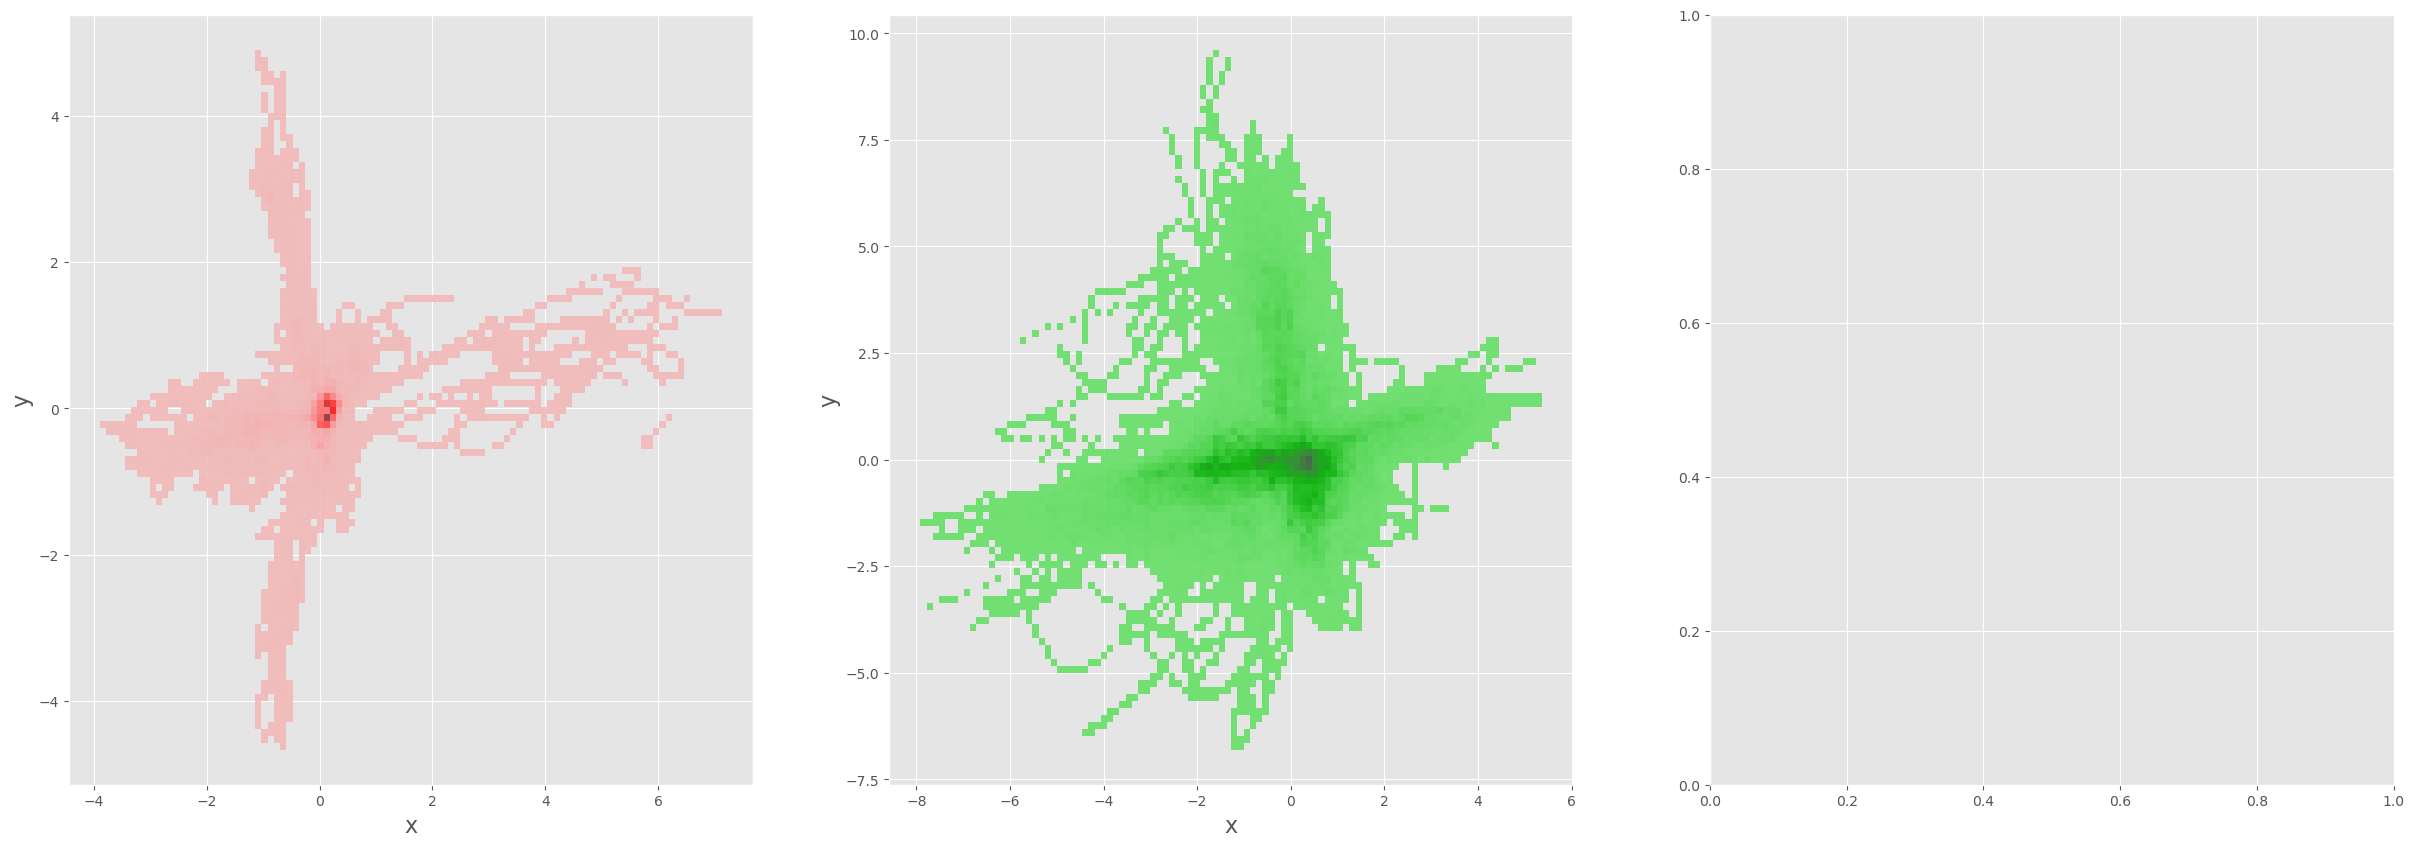

In [9]:
subject_idx = 6
plot_prior_density(subject_idx)

## hit counts per target

In [10]:
test_subject = subjects[subject_idx]
subject_target_hits = []
for subject in subjects:
    target_hits = np.zeros(shape=(12))
    sessions = subject.tasks["center_hold"].sorted_sessions()
    for target_no in range(1,13):
        target_hit_count = 0
        for session in sessions:
            for trial in session.sorted_trials():
                if target_no == trial.target_number and trial.outcome == "Hit":
                    target_hit_count += 1
        target_hits[target_no-1] = target_hit_count
    subject_target_hits.append(target_hits)
subject_target_hits = np.array(subject_target_hits)

## custom histo to compute probabilities

In [11]:
# makes the grid above the data for ggplot
plt.rcParams["axes.axisbelow"] = False

def linear_fit(x_data, y_data):
    result = scipy.stats.linregress(x_data, y_data)
    return result

def plot_linear_fit(x, result, ax):
    ax.plot(x, result.intercept + result.slope*x,"--", color="tab:red", label=f"Linear Fit, $R^2$={np.round(result.rvalue**2, 5)}")

def get_circle_mask(x, y, center, radius):
    mask = (x[np.newaxis,:]-center[0])**2 + (y[:,np.newaxis]-center[1])**2 < radius**2
    return mask[1:,1:]

def get_ellipse_mask(x,y,center,angle,length,width):
    h = center[0]
    k = center[1]
    a = ((x[np.newaxis,:] - h)*np.cos(angle) + (y[:,np.newaxis] - k)*np.sin(angle))**2 / length**2
    b = ((x[np.newaxis,:] - h)*np.sin(angle) - (y[:,np.newaxis] - k)*np.cos(angle))**2 / width**2
    mask = (a + b) <= 1
    return mask[1:,1:]

def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def find_nearest_val(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def get_rectangle_mask(x,y,center,offset):
    row_idx = find_nearest_idx(x, center[0])
    col_idx = find_nearest_idx(y, center[1])
    mask = np.zeros(shape=(x.shape[0],y.shape[0]), dtype=bool)
    mask[row_idx-offset:row_idx+offset, col_idx-offset:col_idx+offset] = True
    return mask[1:,1:]

def compute_histogram(data):
    # number of bins between multiples of 1
    bins_between_1 = 16
    nbins = bins_between_1*4
    xedges = np.linspace(-2,2,nbins,endpoint=True)
    yedges = np.linspace(-2,2,nbins,endpoint=True)
    # pdf = bin_count / sample_count / bin_area
    # multiplying by area and summing (integrating) yields 1
    h, yedges, xedges = np.histogram2d(data[:,0], data[:,1], bins=(xedges, yedges),density=True)
    h = h.T
    return h, xedges, yedges

def compute_probabilities(h,xedges,yedges):
    bin_area = np.abs((xedges[1]-xedges[0]))*np.abs(yedges[1]-yedges[0])
    return h * bin_area

def compute_target_probabilities(probabilities, xedges, yedges):
    X, Y = np.meshgrid(xedges, yedges)
    probabilities_per_target_box = []
    for target_number in range(1,13):
        center = collection.compute_target_vec_from_number(target_number)
        a = collection.compute_theta(center)
        # mask = get_ellipse_mask(X[0,:], Y[:,0], center, a, 0.6, 0.3)
        mask = get_circle_mask(X[0,:],Y[:,0],center,radius=0.3)
        # mask = get_rectangle_mask(X[0,:],Y[:,0],center,2)
        # width of box = 1 + 2*offset
        prob = np.sum(probabilities[ mask])
        probabilities_per_target_box.append(prob)
    return probabilities_per_target_box

def compute_target_coverage(probabilities, xedges, yedges):
    X, Y = np.meshgrid(xedges, yedges)
    coverage_per_target_box = []
    for target_number in range(1,13):
        center = collection.compute_target_vec_from_number(target_number)
        # a = collection.compute_theta(center)
        # mask = get_ellipse_mask(X[0,:], Y[:,0], center, a, 0.5, 0.2)
        mask = get_circle_mask(X[0,:],Y[:,0],center,radius=0.3)
        # width of box = 1 + 2*offset
        # mask = get_rectangle_mask(X[0,:],Y[:,0],center,2)
        coverage = np.array(probabilities > 0.001, dtype=int)
        prob = np.sum(coverage[mask])
        print(prob)
        coverage_per_target_box.append(prob)
    return coverage_per_target_box

def plot_target_probability_histogram(h, xedges, yedges, ax=None):
    # copies of the x-axis (rows)
    # copies of the y-axis (cols)
    X, Y = np.meshgrid(xedges, yedges)
    x = X[0,:]
    y = Y[:,0]
    if ax is None:
        _, ax = plt.subplots(1,1,figsize=(30,10))
    ax.pcolormesh(X, Y, h, cmap='Blues')
    ax.set_xlim([-2,2])
    ax.set_ylim([-2,2])
    ax.set_aspect('equal', 'box')

    t = np.ones_like(h)*-1
    for target_number in range(1,13):
        target_x, target_y = collection.compute_target_vec_from_number(target_number)
        # a = collection.compute_theta([target_x, target_y])
        # mask = get_ellipse_mask(x, y, [target_x, target_y], a, 0.5, 0.2)
        mask = get_circle_mask(x,y,[target_x, target_y],radius=0.3)
        # mask = get_rectangle_mask(x,y,[target_x, target_y],2)
        ax.plot(target_x,target_y,"ro")
        t[mask] = .2
    ax.pcolormesh(X, Y, t, cmap="Blues",alpha=.1)

def multivariate_gaussian(mean,covariance,meshgrid):
    shape = meshgrid.shape[1:]
    x = meshgrid.T.reshape(-1,2)
    shift = x - mean
    # Nx2 2x2 2xN = N x N
    g = np.zeros(shape=shift.shape[0])
    for i, s in enumerate(shift):
        g[i] = np.exp(-s @ np.linalg.inv(covariance) @ s.T / 2.0)
    g /= np.sum(g)
    return g.reshape(shape).T

def blur(image, gaussian):
    return scipy.signal.convolve2d(image, gaussian, mode="same")

(45, 12, 64, 2000)


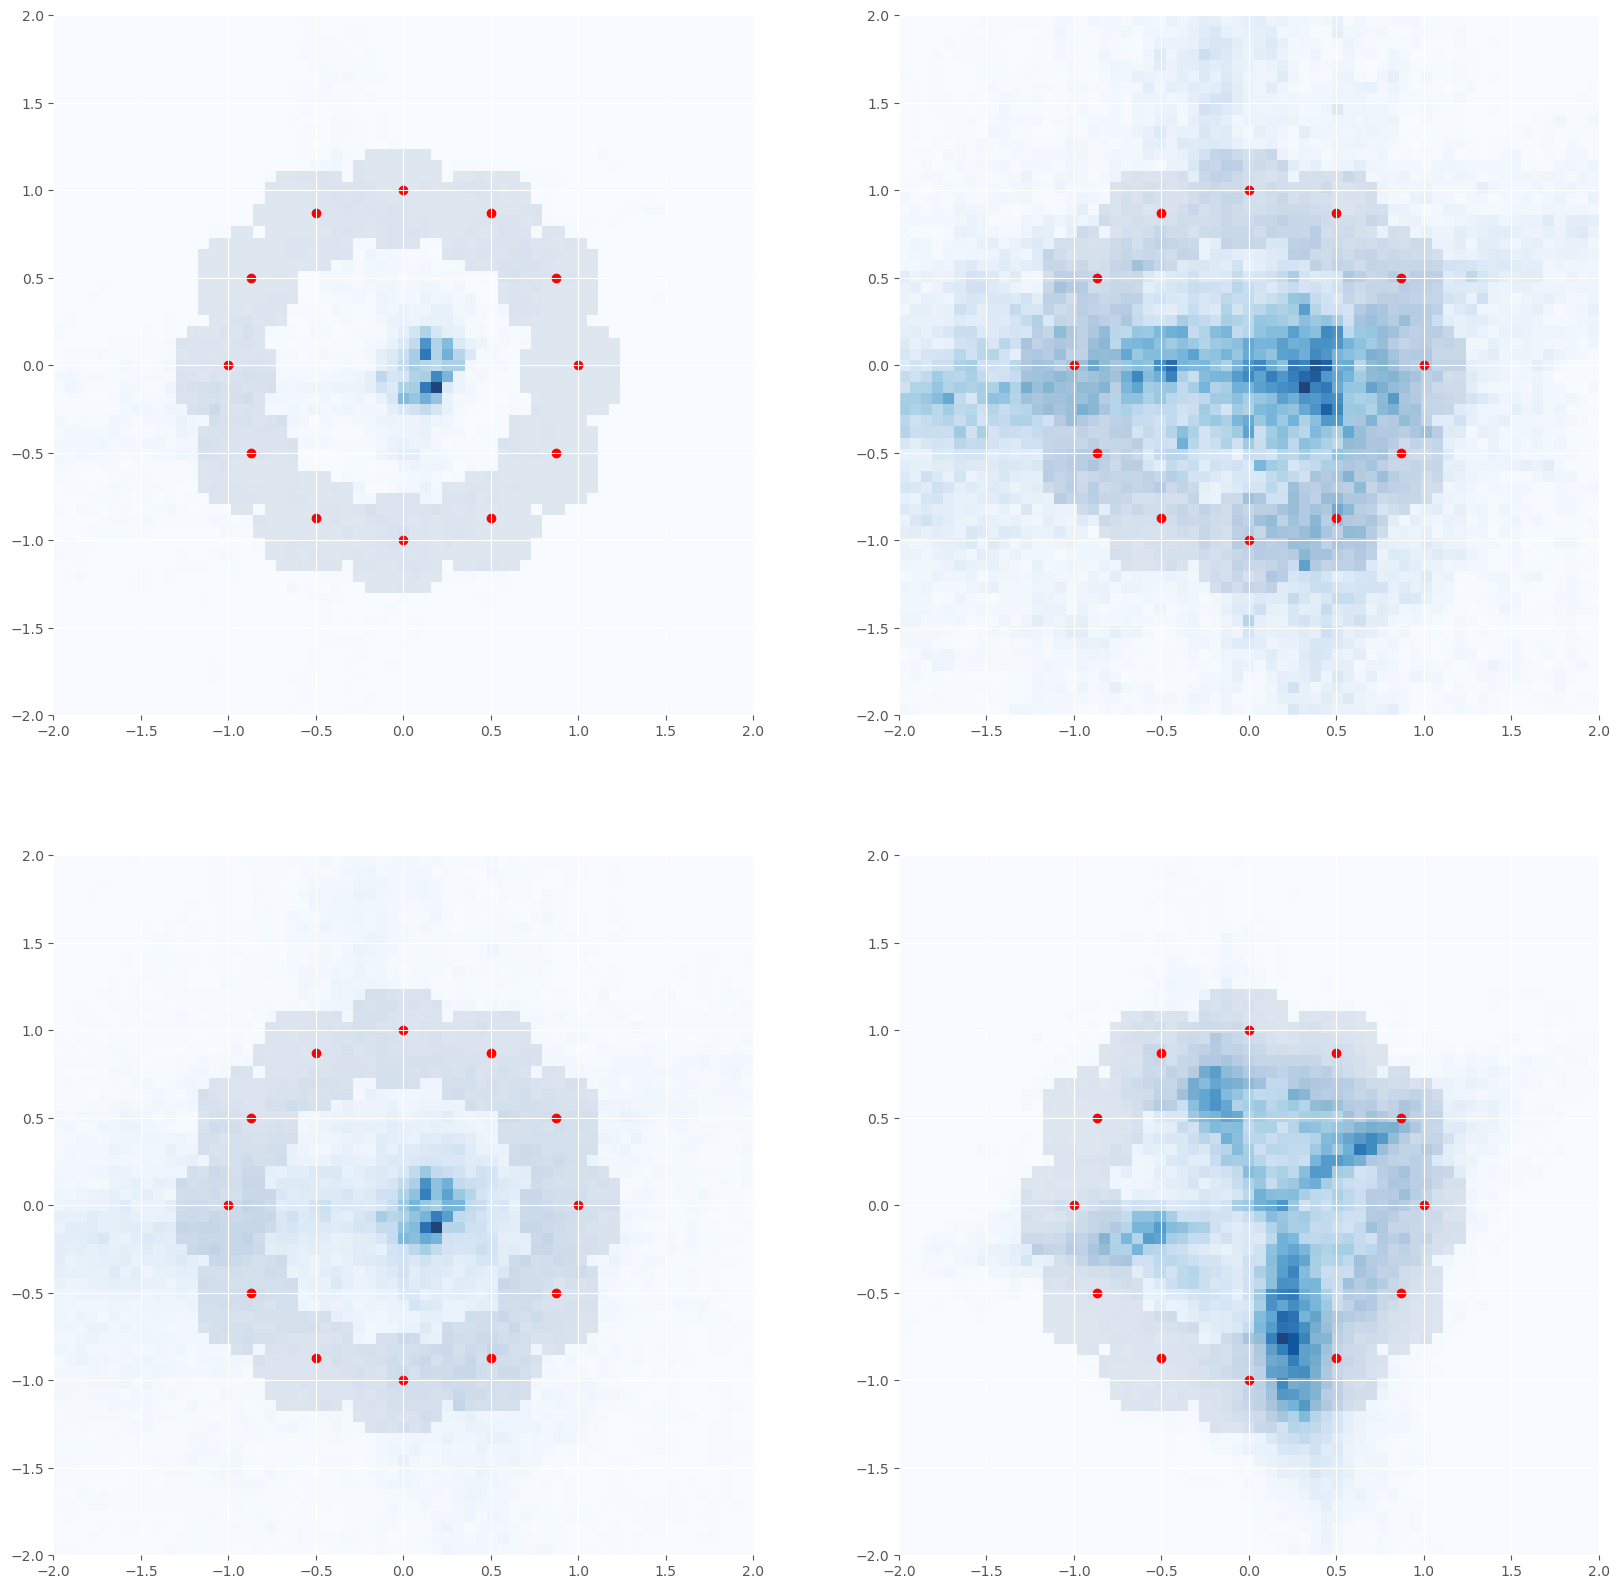

In [19]:
fig, axes = plt.subplots(2,2,figsize=(20,20))

data = subject_movement_stacks[subject_idx].transpose((0,1,3,2)).reshape(-1,64) @ subjects[subject_idx].decoder[-2:,:].T
data = analysis.remove_nan_rows(data)
h, xedges, yedges = compute_histogram(data)
plot_target_probability_histogram(h, xedges, yedges, ax=axes[0,0])

data = subject_calibration_stacks[subject_idx].transpose((0,1,3,2)).reshape(-1,64) @ subjects[subject_idx].decoder[-2:,:].T
data = analysis.remove_nan_rows(data)
h, xedges, yedges = compute_histogram(data)
plot_target_probability_histogram(h, xedges, yedges, ax=axes[0,1])

data1 = subject_calibration_stacks[subject_idx].transpose((0,1,3,2)).reshape(-1,64) @ subjects[subject_idx].decoder[-2:,:].T
data2 = subject_movement_stacks[subject_idx].transpose((0,1,3,2)).reshape(-1,64) @ subjects[subject_idx].decoder[-2:,:].T
data = np.concatenate([data1,data2],axis=0)
data = analysis.remove_nan_rows(data)
h, xedges, yedges = compute_histogram(data)
plot_target_probability_histogram(h, xedges, yedges, ax=axes[1,0])

subject_emg_stack = np.load(f"filtered_stacks/filtered_stack_{subject_idx}.npy")
print(subject_emg_stack.shape)
data = subject_emg_stack.transpose((0,1,3,2)).reshape(-1,64) @ subjects[subject_idx].decoder[-2:,:].T
data = analysis.remove_nan_rows(data)
h, xedges, yedges = compute_histogram(data)
plot_target_probability_histogram(h, xedges, yedges, ax=axes[1,1])

(45, 12, 64, 2000)


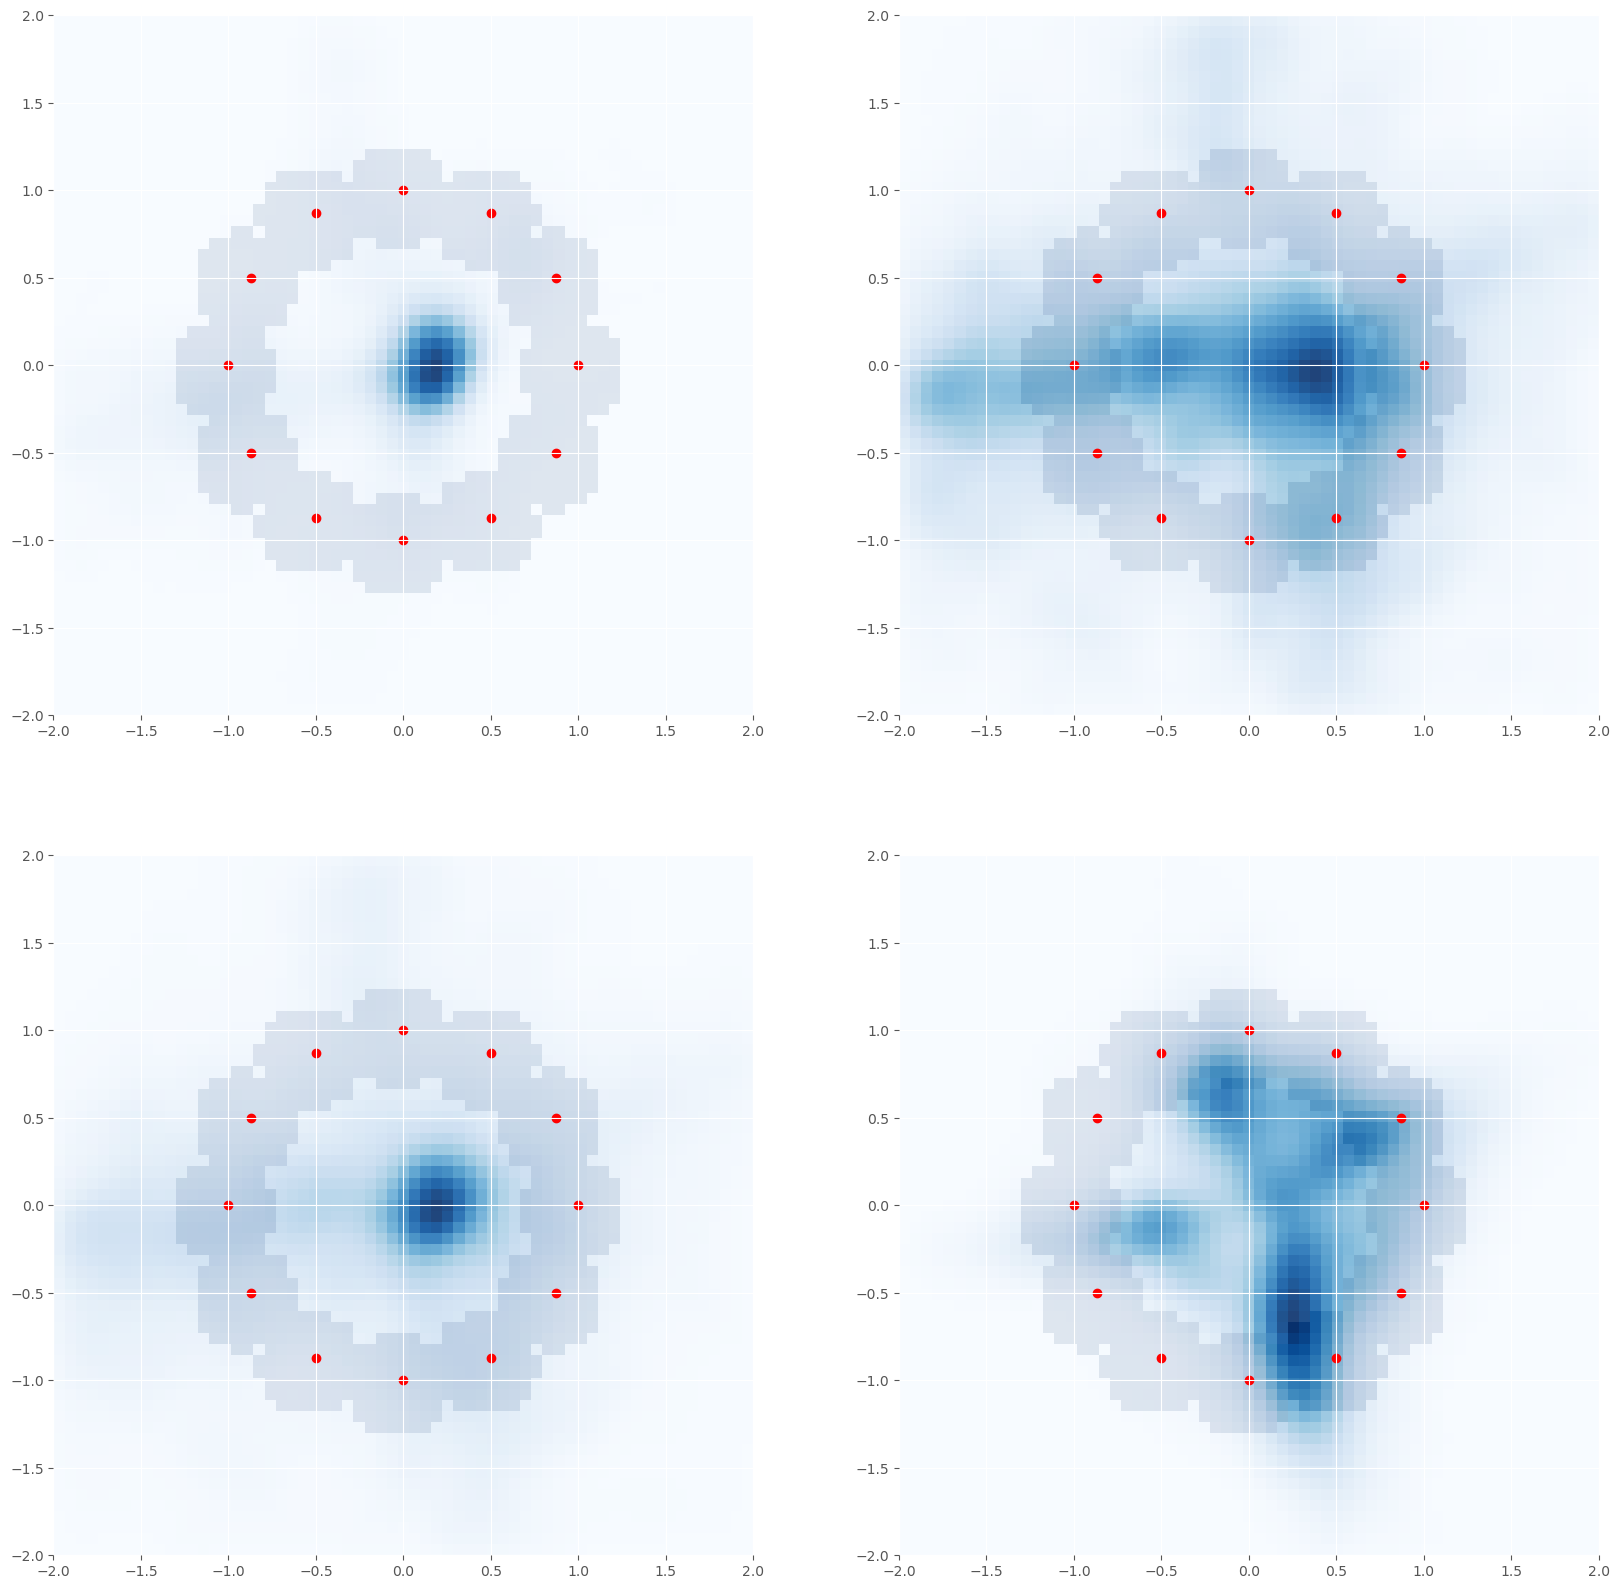

In [20]:
fig, axes = plt.subplots(2,2,figsize=(20,20))

g = multivariate_gaussian(np.zeros(shape=(2,)),np.eye(2)*0.01,np.array(np.meshgrid(xedges, yedges)))

data = subject_movement_stacks[subject_idx].transpose((0,1,3,2)).reshape(-1,64) @ subjects[subject_idx].decoder[-2:,:].T
data = analysis.remove_nan_rows(data)
h, xedges, yedges = compute_histogram(data)
b = blur(h,g)
plot_target_probability_histogram(b, xedges, yedges, ax=axes[0,0])

data = subject_calibration_stacks[subject_idx].transpose((0,1,3,2)).reshape(-1,64) @ subjects[subject_idx].decoder[-2:,:].T
data = analysis.remove_nan_rows(data)
h, xedges, yedges = compute_histogram(data)
b = blur(h,g)
plot_target_probability_histogram(b, xedges, yedges, ax=axes[0,1])

data1 = subject_calibration_stacks[subject_idx].transpose((0,1,3,2)).reshape(-1,64) @ subjects[subject_idx].decoder[-2:,:].T
data2 = subject_movement_stacks[subject_idx].transpose((0,1,3,2)).reshape(-1,64) @ subjects[subject_idx].decoder[-2:,:].T
data = np.concatenate([data1,data2],axis=0)
data = analysis.remove_nan_rows(data)
h, xedges, yedges = compute_histogram(data)
b = blur(h,g)
plot_target_probability_histogram(b, xedges, yedges, ax=axes[1,0])

subject_emg_stack = np.load(f"filtered_stacks/filtered_stack_{subject_idx}.npy")
print(subject_emg_stack.shape)
data = subject_emg_stack.transpose((0,1,3,2)).reshape(-1,64) @ subjects[subject_idx].decoder[-2:,:].T
data = analysis.remove_nan_rows(data)
h, xedges, yedges = compute_histogram(data)
b = blur(h,g)
plot_target_probability_histogram(b, xedges, yedges, ax=axes[1,1])

In [21]:
subject_movement_target_probabilities = []
subject_calibration_target_probabilities = []
subject_prior_target_probabilities = []
subject_trial_target_probabilities = []

subject_movement_probabilities = []
subject_calibration_probabilities = []
subject_prior_probabilities = []
subject_trial_probabilities = []

g = multivariate_gaussian(np.zeros(shape=(2,)),np.eye(2)*0.01,np.array(np.meshgrid(xedges, yedges)))

for subject_idx, subject in enumerate(subjects):

    data = subject_movement_stacks[subject_idx].transpose((0,1,3,2)).reshape(-1,64) @ subjects[subject_idx].decoder[-2:,:].T
    data = analysis.remove_nan_rows(data)
    h, xedges, yedges = compute_histogram(data)
    # h = blur(h,g)
    movement_probabilities = compute_probabilities(h,xedges,yedges)
    probabilities_per_target_box = compute_target_probabilities(movement_probabilities,xedges,yedges)
    # coverage_per_target_box = compute_target_coverage(movement_probabilities,xedges,yedges)
    subject_movement_probabilities.append(movement_probabilities)
    subject_movement_target_probabilities.append(probabilities_per_target_box)
    
    data = subject_calibration_stacks[subject_idx].transpose((0,1,3,2)).reshape(-1,64) @ subjects[subject_idx].decoder[-2:,:].T
    data = analysis.remove_nan_rows(data)
    h, xedges, yedges = compute_histogram(data)
    # h = blur(h,g)
    calibration_probabilities = compute_probabilities(h,xedges,yedges)
    probabilities_per_target_box = compute_target_probabilities(calibration_probabilities,xedges,yedges)
    # coverage_per_target_box = compute_target_coverage(calibration_probabilities,xedges,yedges)
    subject_calibration_probabilities.append(calibration_probabilities)
    subject_calibration_target_probabilities.append(probabilities_per_target_box)

    data1 = subject_calibration_stacks[subject_idx].transpose((0,1,3,2)).reshape(-1,64) @ subjects[subject_idx].decoder[-2:,:].T
    data2 = subject_movement_stacks[subject_idx].transpose((0,1,3,2)).reshape(-1,64) @ subjects[subject_idx].decoder[-2:,:].T
    data = np.concatenate([data1,data2],axis=0)
    data = analysis.remove_nan_rows(data)
    h, xedges, yedges = compute_histogram(data)
    # h = blur(h,g)
    prior_probabilities = compute_probabilities(h,xedges,yedges)
    probabilities_per_target_box = compute_target_probabilities(prior_probabilities,xedges,yedges)
    # coverage_per_target_box = compute_target_coverage(prior_probabilities,xedges,yedges)
    subject_prior_probabilities.append(prior_probabilities)
    subject_prior_target_probabilities.append(probabilities_per_target_box)

    subject_emg_stack = np.load(f"filtered_stacks/filtered_stack_{subject_idx}.npy")
    data = subject_emg_stack.transpose((0,1,3,2)).reshape(-1,64) @ subjects[subject_idx].decoder[-2:,:].T
    data = analysis.remove_nan_rows(data)
    h, xedges, yedges = compute_histogram(data)
    # h = blur(h,g)
    trial_probabilities = compute_probabilities(h,xedges,yedges)
    probabilities_per_target_box = compute_target_probabilities(trial_probabilities,xedges,yedges)
    # coverage_per_target_box = compute_target_coverage(trial_probabilities,xedges,yedges)
    subject_trial_probabilities.append(trial_probabilities)    
    subject_trial_target_probabilities.append(probabilities_per_target_box)

subject_movement_target_probabilities = np.array(subject_movement_target_probabilities)
subject_calibration_target_probabilities = np.array(subject_calibration_target_probabilities)
subject_prior_target_probabilities = np.array(subject_prior_target_probabilities)
subject_trial_target_probabilities = np.array(subject_trial_target_probabilities)

subject_movement_probabilities = np.array(subject_movement_probabilities)
subject_calibration_probabilities = np.array(subject_calibration_probabilities)
subject_prior_probabilities = np.array(subject_prior_probabilities)
subject_trial_probabilities = np.array(subject_trial_probabilities)

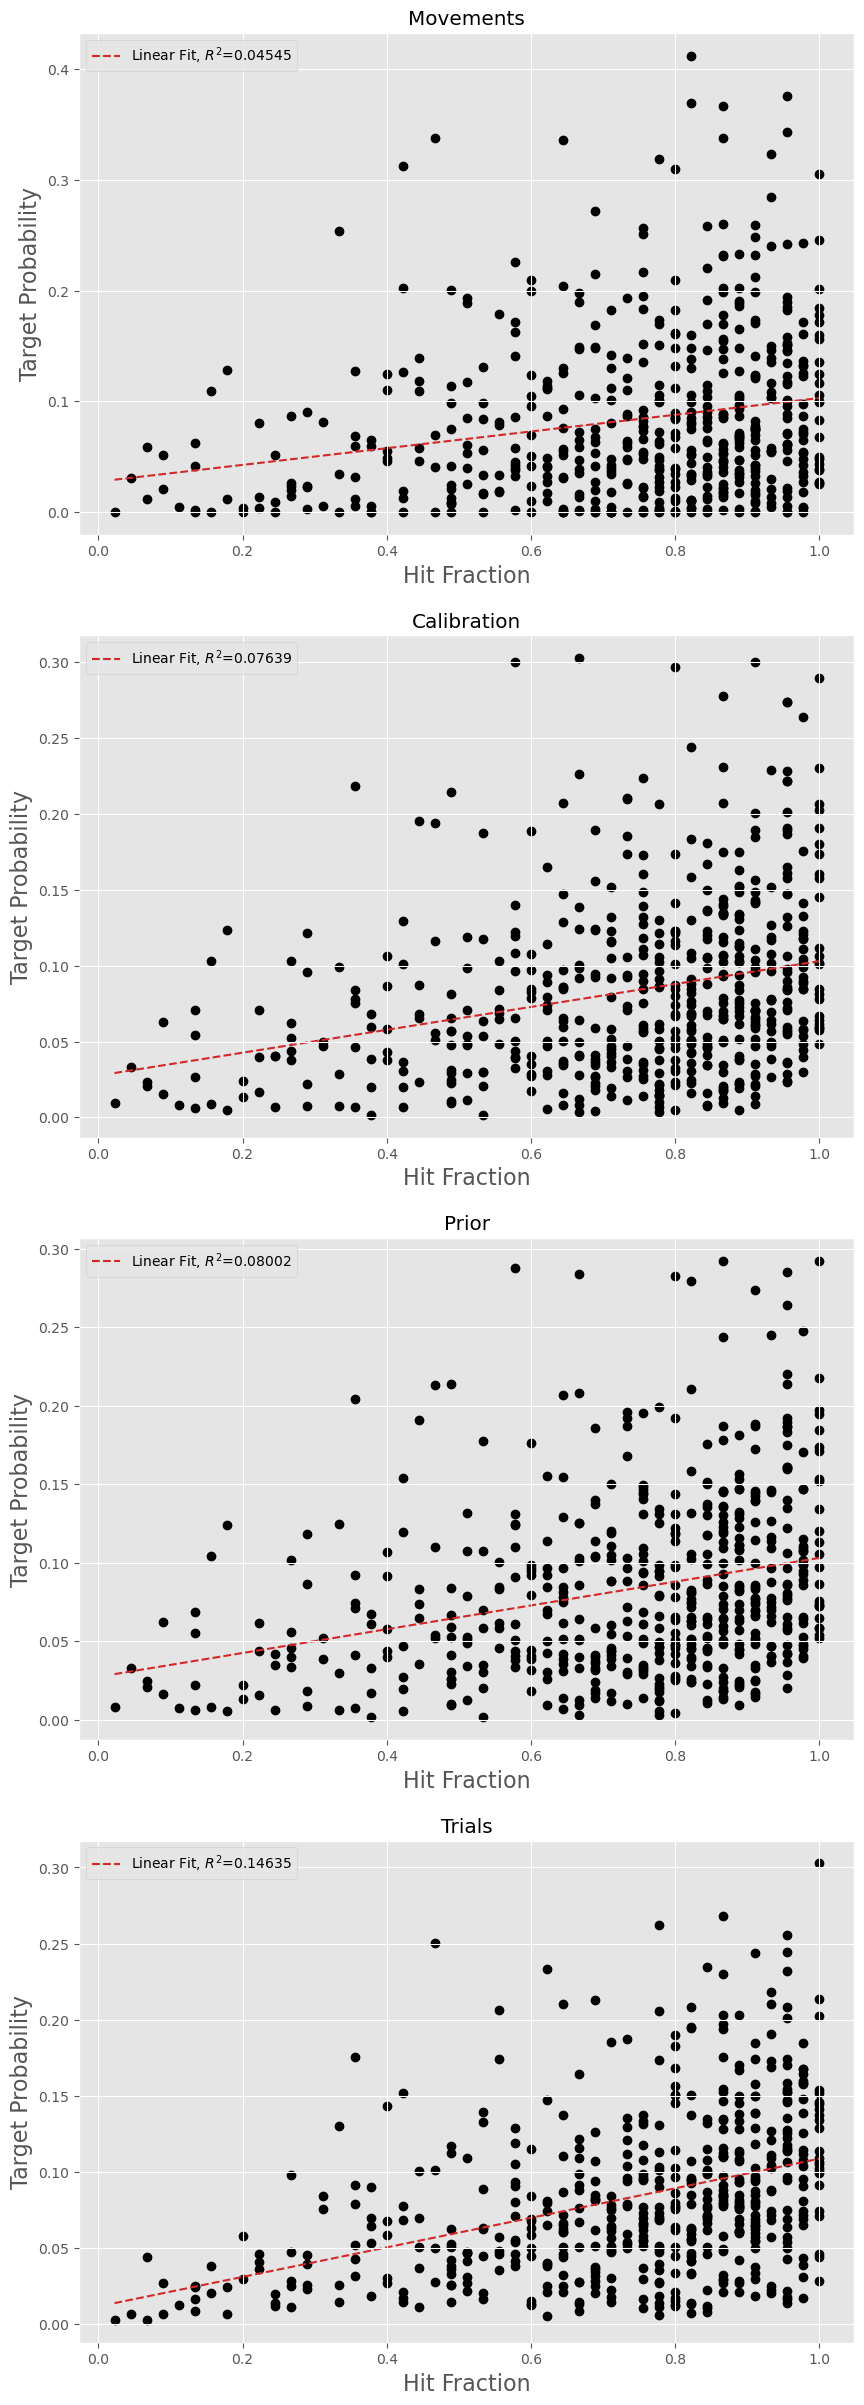

In [22]:
fig, axes = plt.subplots(4,1,figsize=(10,30))

norm_movement_probs = np.divide(subject_movement_target_probabilities, np.sum(subject_movement_target_probabilities,axis=1).reshape(-1,1))
norm_calibration_probs = np.divide(subject_calibration_target_probabilities, np.sum(subject_calibration_target_probabilities,axis=1).reshape(-1,1))
norm_prior_probs = np.divide(subject_prior_target_probabilities, np.sum(subject_prior_target_probabilities,axis=1).reshape(-1,1))
norm_trial_probs = np.divide(subject_trial_target_probabilities, np.sum(subject_trial_target_probabilities,axis=1).reshape(-1,1))

for i in range(46):    
    axes[0].plot(subject_target_hits[i]/45, norm_movement_probs[i], "ko")
    axes[1].plot(subject_target_hits[i]/45, norm_calibration_probs[i], "ko")
    axes[2].plot(subject_target_hits[i]/45, norm_prior_probs[i], "ko")
    axes[3].plot(subject_target_hits[i]/45, norm_trial_probs[i], "ko")

hit_fractions = subject_target_hits.reshape(46*12)/45
x = np.linspace(np.min(hit_fractions),np.max(hit_fractions),len(hit_fractions))
plot_linear_fit(x, linear_fit(hit_fractions, norm_movement_probs.reshape(46*12)),ax=axes[0])
plot_linear_fit(x, linear_fit(hit_fractions, norm_calibration_probs.reshape(46*12)),ax=axes[1])
plot_linear_fit(x, linear_fit(hit_fractions, norm_prior_probs.reshape(46*12)),ax=axes[2])
plot_linear_fit(x, linear_fit(hit_fractions, norm_trial_probs.reshape(46*12)),ax=axes[3])

# for i in range(46):    
#     axes[0].plot(subject_target_hits[i]/45, subject_movement_target_probabilities[i], "ko")
#     axes[1].plot(subject_target_hits[i]/45, subject_calibration_target_probabilities[i], "ko")
#     axes[2].plot(subject_target_hits[i]/45, subject_prior_target_probabilities[i], "ko")
#     axes[3].plot(subject_target_hits[i]/45, subject_trial_target_probabilities[i], "ko")

# hit_fractions = subject_target_hits.reshape(46*12)/45
# x = np.linspace(np.min(hit_fractions),np.max(hit_fractions),len(hit_fractions))
# plot_linear_fit(x, linear_fit(hit_fractions, subject_movement_target_probabilities.reshape(46*12)),ax=axes[0])
# plot_linear_fit(x, linear_fit(hit_fractions, subject_calibration_target_probabilities.reshape(46*12)),ax=axes[1])
# plot_linear_fit(x, linear_fit(hit_fractions, subject_prior_target_probabilities.reshape(46*12)),ax=axes[2])
# plot_linear_fit(x, linear_fit(hit_fractions, subject_trial_target_probabilities.reshape(46*12)),ax=axes[3])

for ax, title in zip(axes, ["Movements", "Calibration","Prior","Trials"]):
    # ax.set_xlim([-0.01,1.1])
    # ax.set_ylim([-0.01,0.25])
    ax.set_xlabel("Hit Fraction")
    ax.set_ylabel("Target Probability")
    ax.set_title(title)
    ax.legend()

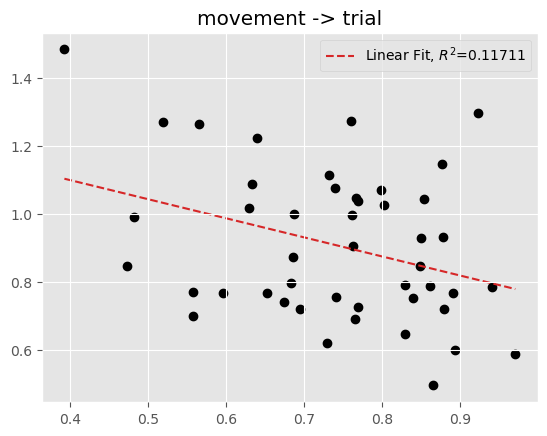

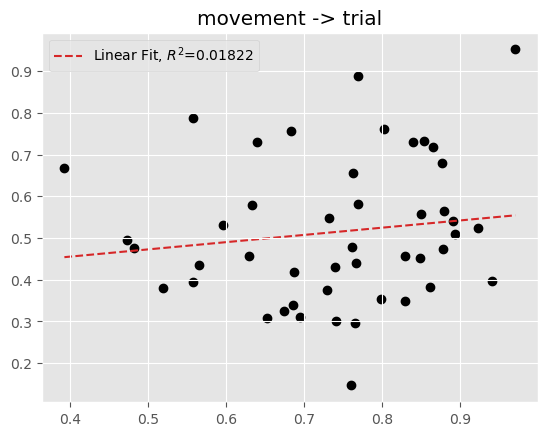

In [118]:
# "excess surprise believing q is true distro when it is actually p"

# p is the "true" distribution, q is the "candidate"
# means movement is the true, actual, surprise at finding this based on trial distro
rel_ents = []
for subject_idx, subject in enumerate(subjects):
    p = subject_movement_probabilities[subject_idx].ravel()
    q = subject_trial_probabilities[subject_idx].ravel()
    mask = np.logical_and(p>0.0, q>0.0)
    p = p[mask]
    q = q[mask]
    rel_ent = np.sum(p * np.log(p / q))
    rel_ents.append(rel_ent)
hit_sums = np.sum(subject_target_hits,axis=1)/540
plt.figure()
plt.title("movement -> trial")
plt.plot(hit_sums,rel_ents,'ko')
result = linear_fit(hit_sums,rel_ents)
x = np.linspace(np.min(hit_sums),np.max(hit_sums),len(hit_sums))
plot_linear_fit(x, result,plt.gca())
plt.legend()

# rel_ents = []
# for subject_idx, subject in enumerate(subjects):
#     p = subject_trial_probabilities[subject_idx].ravel()
#     q = subject_prior_probabilities[subject_idx].ravel()
#     mask = np.logical_and(p>0.0, q>0.0)
#     p = p[mask]
#     q = q[mask]
#     rel_ent = np.sum(p * np.log(p / q))
#     rel_ents.append(rel_ent)
# hit_sums = np.sum(subject_target_hits,axis=1)/540
# plt.figure()
# plt.title("trial -> prior")
# plt.plot(hit_sums,rel_ents,'ko')
# result = linear_fit(hit_sums,rel_ents)
# x = np.linspace(np.min(hit_sums),np.max(hit_sums),len(hit_sums))
# plot_linear_fit(x, result,plt.gca())
# plt.legend()


# rel_ents = []
# for subject_idx, subject in enumerate(subjects):
#     p = subject_calibration_probabilities[subject_idx].ravel()
#     q = subject_trial_probabilities[subject_idx].ravel()
#     mask = np.logical_and(p>0.0, q>0.0)
#     p = p[mask]
#     q = q[mask]
#     rel_ent = np.sum(p * np.log(p / q))
#     rel_ents.append(rel_ent)
# hit_sums = np.sum(subject_target_hits,axis=1)/540
# plt.figure()
# plt.title("calibration -> trial")
# plt.plot(hit_sums,rel_ents,'ko')
# result = linear_fit(hit_sums,rel_ents)
# x = np.linspace(np.min(hit_sums),np.max(hit_sums),len(hit_sums))
# plot_linear_fit(x, result,plt.gca())
# plt.legend()


# rel_ents = []
# for subject_idx, subject in enumerate(subjects):
#     p = subject_trial_probabilities[subject_idx].ravel()
#     q = subject_movement_probabilities[subject_idx].ravel()
#     mask = np.logical_and(p>0.0, q>0.0)
#     p = p[mask]
#     q = q[mask]
#     rel_ent = np.sum(p * np.log(p / q))
#     rel_ents.append(rel_ent)
# hit_sums = np.sum(subject_target_hits,axis=1)/540
# plt.figure()
# plt.title("trial -> movement")
# plt.plot(hit_sums,rel_ents,'ko')
# result = linear_fit(hit_sums,rel_ents)
# x = np.linspace(np.min(hit_sums),np.max(hit_sums),len(hit_sums))
# plot_linear_fit(x, result,plt.gca())
# plt.legend()


# rel_ents = []
# for subject_idx, subject in enumerate(subjects):
#     p = subject_trial_probabilities[subject_idx].ravel()
#     q = subject_calibration_probabilities[subject_idx].ravel()
#     mask = np.logical_and(p>0.0, q>0.0)
#     p = p[mask]
#     q = q[mask]
#     rel_ent = np.sum(p * np.log(p / q))
#     rel_ents.append(rel_ent)
# hit_sums = np.sum(subject_target_hits,axis=1)/540
# plt.figure()
# plt.title("trial -> calibration")
# plt.plot(hit_sums,rel_ents,'ko')
# result = linear_fit(hit_sums,rel_ents)
# x = np.linspace(np.min(hit_sums),np.max(hit_sums),len(hit_sums))
# plot_linear_fit(x, result,plt.gca())
# plt.legend()

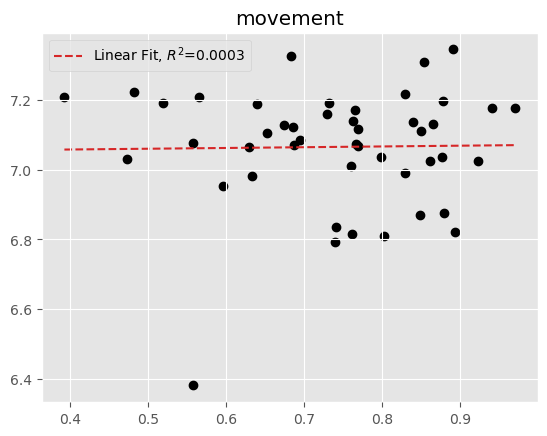

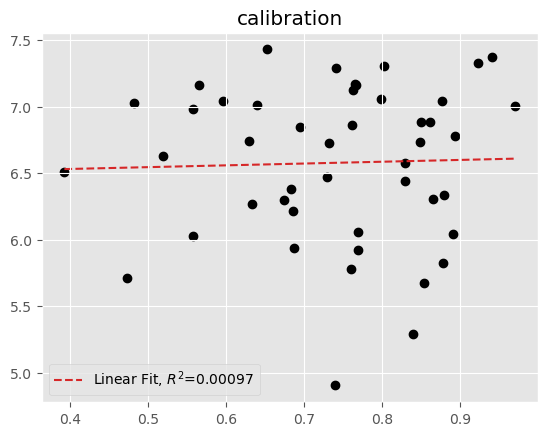

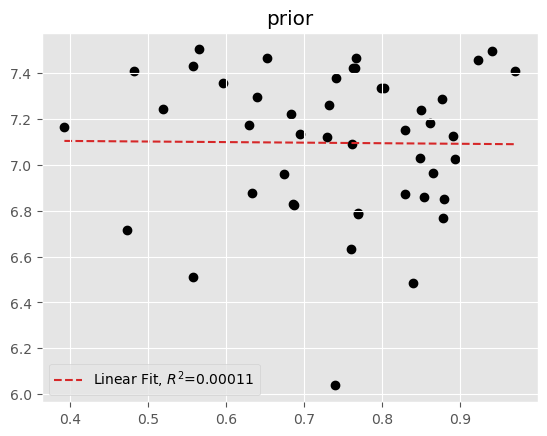

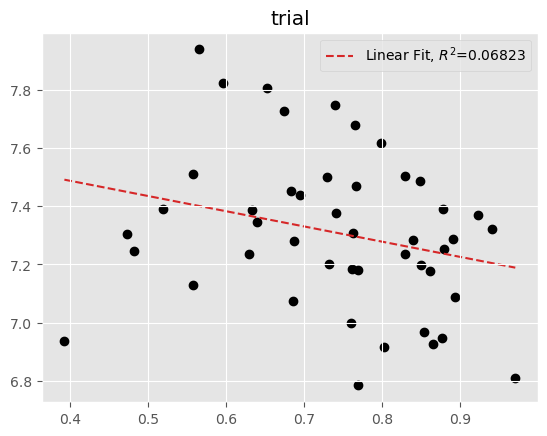

In [120]:
def entropy(array):
    p = array[array > 0.0]
    return -np.sum(p*np.log(p))

entropies = []
for subject_idx, subject in enumerate(subjects):
    entropies.append(entropy(subject_movement_probabilities[subject_idx].ravel()))
hit_sums = np.sum(subject_target_hits,axis=1)/540
plt.figure()
plt.title("movement")
plt.plot(hit_sums,entropies,'ko')
result = linear_fit(hit_sums,entropies)
x = np.linspace(np.min(hit_sums),np.max(hit_sums),len(hit_sums))
plot_linear_fit(x, result,plt.gca())
plt.legend()


entropies = []
for subject_idx, subject in enumerate(subjects):
    entropies.append(entropy(subject_calibration_probabilities[subject_idx].ravel()))
hit_sums = np.sum(subject_target_hits,axis=1)/540
plt.figure()
plt.title("calibration")
plt.plot(hit_sums,entropies,'ko')
result = linear_fit(hit_sums,entropies)
x = np.linspace(np.min(hit_sums),np.max(hit_sums),len(hit_sums))
plot_linear_fit(x, result,plt.gca())
plt.legend()

entropies = []
for subject_idx, subject in enumerate(subjects):
    entropies.append(entropy(subject_prior_probabilities[subject_idx].ravel()))
hit_sums = np.sum(subject_target_hits,axis=1)/540
plt.figure()
plt.title("prior")
plt.plot(hit_sums,entropies,'ko')
result = linear_fit(hit_sums,entropies)
x = np.linspace(np.min(hit_sums),np.max(hit_sums),len(hit_sums))
plot_linear_fit(x, result,plt.gca())
plt.legend()


entropies = []
for subject_idx, subject in enumerate(subjects):
    entropies.append(entropy(subject_trial_probabilities[subject_idx].ravel()))
hit_sums = np.sum(subject_target_hits,axis=1)/540
plt.figure()
plt.title("trial")
plt.plot(hit_sums,entropies,'ko')
result = linear_fit(hit_sums,entropies)
x = np.linspace(np.min(hit_sums),np.max(hit_sums),len(hit_sums))
plot_linear_fit(x, result,plt.gca())
plt.legend()